# NGSA FINAL PROJECT

# Recommendation Systems with Amazon Co-Purchasing Network

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import itertools
import math
import pandas as pd
import numpy as np
import time
import re
from scipy.sparse.linalg import svds
import ast

## Parser used for the metadata file

In [19]:
def split_iter(string):
    # Splitting on each product, i.e. b
    return (x.group(0) for x in re.finditer(r":([\w\W])*?\nId", string))

In [20]:
def parser(items, start=0, num_items=5000, flat=False):
    df = pd.DataFrame(columns=['id','asin','discountinued','title','groupe','salesrank','num_similar',\
                               'similar','num_categories','categories','num_reviews','downloaded_reviews',\
                               'avg_rating','dates','customer_ids','ratings','votes','helpfuls'])
    if start == 0:
        next(items)
    i = start
    while i < num_items:
        try:
            item = next(items).split('\n')
            id,asin = item[:2]
            id = id.replace(' ', '')
            id = int(id[id.index(':')+1:])
            asin = asin.replace(' ', '')
            asin = asin[asin.index(':')+1:]
            if len(item) == 5 :
                df.loc[i] = [None for i in range(len(df.columns))] 
                df.loc[i]['discountinued'] = True
                df.loc[i]['id'] = id
                df.loc[i]['asin'] = asin
            elif len(item) > 5:
                    title,groupe,salesrank,similar,num_categories = item[2:7]
                    rest = item[7:]
                    title = title[title.index(':')+2:]
                    groupe = groupe[groupe.index(':')+2:]
                    salesrank = int(salesrank[salesrank.index(':')+2:])
                    similar = similar[similar.index(':')+2:].split()
                    num_similar = int(similar[0])
                    similar = similar[1:]
                    num_categories = int(num_categories[num_categories.index(':')+2:])
                    j = 0
                    l = len(rest)
                    categories = []
                    reviews = []
                    while not 'reviews' in rest[j]:
                        categories.append(rest[j])
                        j+=1
                    s = rest[j][rest[j].index(':')+1:]
                    num_reviews,downloaded_reviews,avg_rating = [int(x[0]) for x in s.split(': ')[1:]]
                    j +=1
                    while j < l:
                        if rest !='':
                            reviews.append(rest[j])
                            j+=1
                    dates = []
                    customer_ids = []
                    ratings = []
                    votes = []
                    helpfuls = []
                    for review in reviews:
                        if review not in ['','Id'] :
                            parsed = [x for x in review.split(': ')]
                            date = parsed[0].replace(' ', '')
                            dates.append(date[:date.index('cutomer')])
                            customer_ids.append(parsed[1][:parsed[1].index('rating')-1])
                            ratings.append(int(parsed[2][:parsed[2].index('votes')-1]))
                            votes.append(int(parsed[3][:parsed[3].index('helpful')-1]))
                            helpfuls.append(int(parsed[4]))
                    if flat:
                        k = 0 
                        while k < len(customer_ids):
                            row = [id,asin,False,title,groupe,salesrank,num_similar,similar,num_categories,categories,\
                                  num_reviews,downloaded_reviews,avg_rating, dates[k], customer_ids[k], ratings[k], votes[k], helpfuls[k]]
                            df.loc[i] = row
                            i+=1
                            k+=1
                        if k > 0:
                            i -= 1
                    else:
                        row = [id,asin,False,title,groupe,salesrank,num_similar,similar,num_categories,categories,\
                              num_reviews,downloaded_reviews,avg_rating, dates, customer_ids, ratings, votes, helpfuls]
                        df.loc[i] = row
                        
        except Exception as e:
#             print(e)
#             print(row)
            pass
        i+= 1
    return df

In [21]:
text = open('amazon-meta.txt', 'r', encoding='utf-8').read()
splited_text = split_iter(text)

In [22]:
t = time.time()
df = pd.DataFrame(columns=['id','asin','discountinued','title','groupe','salesrank','num_similar',\
                               'similar','num_categories','categories','num_reviews','downloaded_reviews',\
                               'avg_rating','dates','customer_ids','ratings','votes','helpfuls'])

In [23]:
for i in range(200,240):
    print('{} '.format(i))
    df_parsed = parser(splited_text, flat=True, start = i*5000, num_items=(i+1)*5000)
    df = pd.concat([df, df_parsed], axis=0)
    print('{} seconds'.format(time.time()-t))

200 
34.92643189430237 seconds
201 
65.73542261123657 seconds
202 
96.7761504650116 seconds
203 
125.11287236213684 seconds
204 
153.46359872817993 seconds
205 
181.24443769454956 seconds
206 
208.0992648601532 seconds
207 
240.68635320663452 seconds
208 
271.5680193901062 seconds
209 
300.83380603790283 seconds
210 
330.1632800102234 seconds
211 
358.6002130508423 seconds
212 
387.7361099720001 seconds
213 
445.17242074012756 seconds
214 
475.27351903915405 seconds
215 
503.0527482032776 seconds
216 
531.4677686691284 seconds
217 
570.0148651599884 seconds
218 
599.1394805908203 seconds
219 
625.8947141170502 seconds
220 
654.3328297138214 seconds
221 
682.0468907356262 seconds
222 
712.5823125839233 seconds
223 
741.6261582374573 seconds
224 
769.5530641078949 seconds
225 
800.1725795269012 seconds
226 
829.0684106349945 seconds
227 
856.1780369281769 seconds
228 
884.8810658454895 seconds
229 
913.540741443634 seconds
230 
940.4845697879791 seconds
231 
970.6825058460236 seconds
232

## Write the dataframe to the csv

In [24]:
df.to_csv('amazon-meta_.csv')

## Recommendation using communities and motifs

#### Reading which products we will work on

In [25]:
with open('ids_last.txt', 'r') as file:
        important_nodes = file.read()
    
# Let's put the node we will work on in a dictionnary with the value 1
important_nodes_dict = {}

for node in important_nodes.split(' '):
    important_nodes_dict[node[:-1]] = 1
    
print(len(important_nodes.split(' ')))
print(len(important_nodes_dict.keys()))

8090
8090


#### Creating the graph

In [26]:
with open('Amazon0302.txt', 'r') as f:
    data = f.read()
data = data.split('\n')

# Creation of the Digraph using the data

G = nx.DiGraph()

for row in range(4, len(data)-1):
    dataaa = data[row].split('\t')
    node_1 = dataaa[0]
    node_2 = dataaa[1]
    
    # If both nodes are in the dictionnary, it means that we will work with the edge and
    # we add it to the graph
    nodes_to_add = 0
    nodes_to_add += important_nodes_dict.get(node_1, 0)
    nodes_to_add += important_nodes_dict.get(node_2, 0)
    
    if nodes_to_add == 2:
        G.add_edge(node_1, node_2)

# nx.draw(G)
# plt.show()        

#### Detecting Motif 1

In [27]:
motif_1_nodes = []
motif_1_edges = []

print(len(G.edges))

# Detection of the Motif 1 in the Directed graph
for edge_1 in tqdm(G.edges):
    node_1 = edge_1[0]
    node_2 = edge_1[1]
    for edge_2 in G.edges:
        if edge_2[0] == node_1 and edge_2[1] != node_2:
            motif_1_nodes.append([node_1, node_2, edge_2[1]])
            motif_1_edges.append([edge_1, edge_2])
        if edge_2[1] == node_1 and edge_2[0] != node_2:
            motif_1_nodes.append([node_1, node_2, edge_2[0]])
            motif_1_edges.append([edge_1, edge_2])
            
print(len(motif_1_nodes)/2)

5397


A Jupyter Widget


3441.0


#### Detecting Motif 3

A Jupyter Widget


Examples of Nodes forming a Motif-3
[['16', '19', '73'], ['16', '73', '19'], ['19', '16', '73'], ['19', '73', '16'], ['73', '16', '19'], ['73', '19', '16'], ['291', '82', '678'], ['117', '97', '131'], ['117', '131', '97'], ['162', '616', '53']]


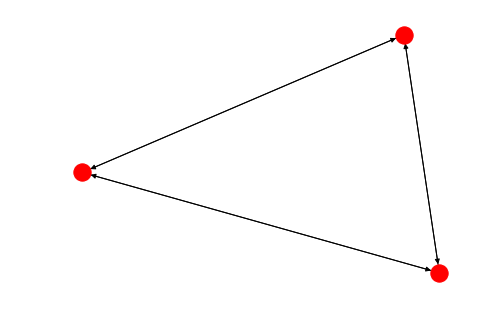

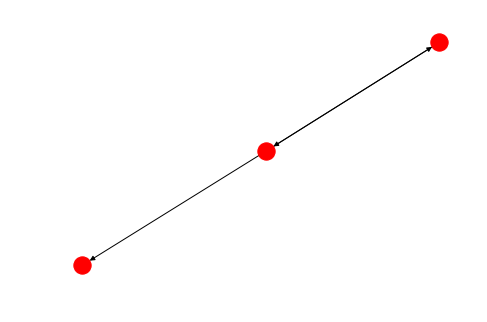

In [28]:
motif_3_nodes = []
motif_3_edges = []

# Detection of the Motif 3 in the Directed graph
for edge_1 in tqdm(G.edges()):
    node_1 = edge_1[0]
    node_2 = edge_1[1]
    for edge_2 in G.edges():
        if edge_2[0] == node_2 and edge_2[1] == node_1:
            for edge_3 in G.edges():
                if edge_3[0] == node_1 and edge_3[1] != node_2:
                    motif_3_nodes.append([node_1, node_2, edge_3[1]])
                    motif_3_edges.append([edge_1, edge_2, edge_3])
                        

print('Examples of Nodes forming a Motif-3')
print(motif_3_nodes[:10])
# Let's Display an example of the Motif 3
H = G.subgraph(motif_3_nodes[0])
nx.draw(H)
plt.show()


# print(motif_3_edges[0])
W = nx.DiGraph()
                                                                                            
W.add_edge(motif_3_edges[0][0][0], motif_3_edges[0][0][1])
W.add_edge(motif_3_edges[0][1][0], motif_3_edges[0][1][1])
W.add_edge(motif_3_edges[0][2][0], motif_3_edges[0][2][1])

nx.draw(W)  
plt.show()

#### Detecting Motif 4

In [29]:
motif_4_nodes = []
motif_4_edges = []

# Detection of the Motif 4 in the Directed Graph
for edge_1 in tqdm(G.edges):
    node_1 = edge_1[0]
    node_2 = edge_1[1]
    for edge_2 in G.edges:
        if edge_2[0] == node_2 and edge_2[1] != node_1:
            motif_4_nodes.append([node_1, node_2, edge_2[1]])
            motif_4_edges.append([edge_1, edge_2])
        if edge_2[1] == node_2 and edge_2[0] != node_1:
            motif_4_nodes.append([node_1, node_2, edge_2[0]])
            motif_4_edges.append([edge_1, edge_2])

print(len(motif_4_edges))

A Jupyter Widget


11310


#### Detecting Motif 10

In [30]:
motif_10_nodes = []
motif_10_edges = []

# Detection of the Motif 10 in the Directed Graph
for edge_1 in tqdm(G.edges):
    node_1 = edge_1[0]
    node_2 = edge_2[1]
    
    for edge_2 in G.edges:
        if edge_2[0] == node_2 and edge_2[1] == node_1:
            
            for edge_3 in G.edges:
                if edge_3[1] == node_1 and edge_3[0] != node_2:
                    
                    motif_10_nodes.append([node_1, node_2, edge_3[0]])
                    motif_10_edges.append([edgs_1, edge_2, edge_3])

print(len(motif_10_nodes))

A Jupyter Widget


0


#### Building unDirected Graph in order to detect overlapping communities

In [31]:
from networkx.algorithms.community import greedy_modularity_communities

with open('Amazon0302.txt', 'r') as f:
    data = f.read()
data = data.split('\n')

# Creation of the Graph (not directed) to work with the communities algorithms
G_u = nx.Graph()

for row in range(4, len(data)-1):
    dataaa = data[row].split('\t')
    node_1 = dataaa[0]
    node_2 = dataaa[1]
    
    nodes_to_add = 0
    nodes_to_add += important_nodes_dict.get(node_1, 0)
    nodes_to_add += important_nodes_dict.get(node_2, 0)
    
    if nodes_to_add == 2:
        G_u.add_edge(node_1, node_2)

print(len(G_u.nodes))
c = list(greedy_modularity_communities(G_u))

4871


#### Overlapping Communities Algorithm

In [32]:
from itertools import combinations


# Use of the Clique Percolation Algorithm in order to work on overlapping communities
def get_percolated_cliques(G, k):
    # G is the graph to work on, k the maximum distance
    perc_graph = nx.Graph()
    cliques = list(frozenset(c) for c in nx.find_cliques(G) if len(c) >= k)
    perc_graph.add_nodes_from(cliques)

    # Add an edge in the clique graph for each pair of cliques that percolate
    for c1, c2 in combinations(cliques, 2):
        if len(c1.intersection(c2)) >= (k - 1):
            perc_graph.add_edge(c1, c2)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

In [33]:
# Get the overlapping communities
mygenerator = get_percolated_cliques(G_u, 3)
c = 0
tt_list = []
for i in mygenerator:
    print(i)
    c += len(i)
    tt_list.append(list(i))

frozenset({'7108', '16567', '3227', '7109', '7107', '16565'})
frozenset({'49348', '49352', '49350'})
frozenset({'29820', '3589', '4930', '22904', '4934'})
frozenset({'21090', '22901', '22904'})
frozenset({'26204', '26203', '38476'})
frozenset({'1797', '2050', '5063', '3145', '36044', '20030', '2051'})
frozenset({'31447', '30976', '21331'})
frozenset({'37901', '13836', '27414'})
frozenset({'42400', '42399', '43035'})
frozenset({'13615', '15473', '15472', '15471', '14144'})
frozenset({'22629', '15187', '16582'})
frozenset({'42105', '47126', '47125'})
frozenset({'8854', '8857', '6960', '28589'})
frozenset({'48155', '48157', '38902'})
frozenset({'2368', '4146', '4147'})
frozenset({'39827', '16090', '14287'})
frozenset({'26262', '26263', '13159'})
frozenset({'31075', '51565', '51563'})
frozenset({'16974', '20646', '16972', '16971', '20645'})
frozenset({'17874', '12044', '15700'})
frozenset({'23608', '15450', '29580', '23609'})
frozenset({'28239', '35413', '35412', '35411'})
frozenset({'5526

In [34]:
print(len(G_u.nodes))

4871


In [35]:
print(c)

1006


#### Test of the Recommendation System

In [36]:
# Node for which we are looking for recommandation
node_to_test = '1468'

motif_1_dict = {}
motif_total = {}

for i in tqdm(motif_1_nodes):
    # Count the number of motives the other nodes are involved in, along with the working node
    if node_to_test in i:
        motif_1_dict[i[0]] = motif_1_dict.get(i[0], 0) + 1
        motif_1_dict[i[1]] = motif_1_dict.get(i[1], 0) + 1
        motif_1_dict[i[2]] = motif_1_dict.get(i[2], 0) + 1
        motif_total[i[0]] = motif_total.get(i[0], 0) + 1
        motif_total[i[1]] = motif_total.get(i[1], 0) + 1
        motif_total[i[2]] = motif_total.get(i[2], 0) + 1

A Jupyter Widget

In [37]:
print(motif_1_dict)

{'337': 17, '1154': 23, '1468': 35, '1156': 1, '481': 11, '2452': 17, '42500': 1}


In [38]:
motif_3_dict = {}

for i in motif_3_nodes:
    # Same for motif 3
    if node_to_test in i:
        motif_3_dict[i[0]] = motif_3_dict.get(i[0], 0) + 1
        motif_3_dict[i[1]] = motif_3_dict.get(i[1], 0) + 1
        motif_3_dict[i[2]] = motif_3_dict.get(i[2], 0) + 1
        motif_total[i[0]] = motif_total.get(i[0], 0) + 1
        motif_total[i[1]] = motif_total.get(i[1], 0) + 1
        motif_total[i[2]] = motif_total.get(i[2], 0) + 1
        
print(motif_3_dict)

{'1154': 8, '337': 5, '1468': 11, '481': 3, '2452': 6}


In [39]:
motif_4_dict = {}

for i in motif_4_nodes:
    # Same for motif 4
    if node_to_test in i:
        motif_4_dict[i[0]] = motif_4_dict.get(i[0], 0) + 1
        motif_4_dict[i[1]] = motif_4_dict.get(i[1], 0) + 1
        motif_4_dict[i[2]] = motif_4_dict.get(i[2], 0) + 1
        motif_total[i[0]] = motif_total.get(i[0], 0) + 1
        motif_total[i[1]] = motif_total.get(i[1], 0) + 1
        motif_total[i[2]] = motif_total.get(i[2], 0) + 1
        
print(motif_4_dict)

{'230': 2, '337': 21, '1468': 63, '1154': 23, '481': 31, '2452': 13, '1156': 3, '609': 2, '18360': 2, '27679': 2, '42500': 5, '1206': 2, '2772': 2, '5085': 2, '5851': 2, '7839': 2, '8853': 2, '14583': 2, '24501': 2, '22784': 2, '25341': 2, '28033': 2}


In [40]:
motif_10_dict = {}

for i in motif_10_nodes:
    # Same for motif 10
    if node_to_test in i:
        motif_10_dict[i[0]] = motif_10_dict.get(i[0], 0) + 1
        motif_10_dict[i[1]] = motif_10_dict.get(i[1], 0) + 1
        motif_10_dict[i[2]] = motif_10_dict.get(i[2], 0) + 1
        motif_total[i[0]] = motif_total.get(i[0], 0) + 1
        motif_total[i[1]] = motif_total.get(i[1], 0) + 1
        motif_total[i[2]] = motif_total.get(i[2], 0) + 1
        
print(motif_10_dict)

{}


In [41]:
print(motif_total)
# Get the number of motifs with the working node nodes are involved in

{'337': 43, '1154': 54, '1468': 109, '1156': 4, '481': 45, '2452': 36, '42500': 6, '230': 2, '609': 2, '18360': 2, '27679': 2, '1206': 2, '2772': 2, '5085': 2, '5851': 2, '7839': 2, '8853': 2, '14583': 2, '24501': 2, '22784': 2, '25341': 2, '28033': 2}


In [42]:
# Rank these nodes
s = [(k, motif_total[k]) for k in sorted(motif_total, key=motif_total.get, reverse=True)]
for k, v in s:
    print(k, v)

1468 109
1154 54
481 45
337 43
2452 36
42500 6
1156 4
230 2
609 2
18360 2
27679 2
1206 2
2772 2
5085 2
5851 2
7839 2
8853 2
14583 2
24501 2
22784 2
25341 2
28033 2


#### Building a Recommendation Function

In [43]:
# Let's work with several nodes

def recommendation(nodes_list, n_recommendation):
    return_list = []
    for node_to_test in nodes_list:

        community = []

        for i in tt_list:
            if node_to_test in i:
    #             print('ttlist', i)
                community += i

        motif_1_dict = {}
        motif_total = {}

        for i in motif_1_nodes:
            if node_to_test in i:
                motif_1_dict[i[0]] = motif_1_dict.get(i[0], 0) + 1
                motif_1_dict[i[1]] = motif_1_dict.get(i[1], 0) + 1
                motif_1_dict[i[2]] = motif_1_dict.get(i[2], 0) + 1
                motif_total[i[0]] = motif_total.get(i[0], 0) + 1
                motif_total[i[1]] = motif_total.get(i[1], 0) + 1
                motif_total[i[2]] = motif_total.get(i[2], 0) + 1

        motif_3_dict = {}

        for i in motif_3_nodes:
            if node_to_test in i:
                motif_3_dict[i[0]] = motif_3_dict.get(i[0], 0) + 1
                motif_3_dict[i[1]] = motif_3_dict.get(i[1], 0) + 1
                motif_3_dict[i[2]] = motif_3_dict.get(i[2], 0) + 1
                motif_total[i[0]] = motif_total.get(i[0], 0) + 1
                motif_total[i[1]] = motif_total.get(i[1], 0) + 1
                motif_total[i[2]] = motif_total.get(i[2], 0) + 1


        motif_4_dict = {}

        for i in motif_4_nodes:
            if node_to_test in i:
                motif_4_dict[i[0]] = motif_4_dict.get(i[0], 0) + 1
                motif_4_dict[i[1]] = motif_4_dict.get(i[1], 0) + 1
                motif_4_dict[i[2]] = motif_4_dict.get(i[2], 0) + 1
                motif_total[i[0]] = motif_total.get(i[0], 0) + 1
                motif_total[i[1]] = motif_total.get(i[1], 0) + 1
                motif_total[i[2]] = motif_total.get(i[2], 0) + 1

        motif_10_dict = {}

        for i in motif_10_nodes:
            if node_to_test in i:
                motif_10_dict[i[0]] = motif_10_dict.get(i[0], 0) + 1
                motif_10_dict[i[1]] = motif_10_dict.get(i[1], 0) + 1
                motif_10_dict[i[2]] = motif_10_dict.get(i[2], 0) + 1
                motif_total[i[0]] = motif_total.get(i[0], 0) + 1
                motif_total[i[1]] = motif_total.get(i[1], 0) + 1
                motif_total[i[2]] = motif_total.get(i[2], 0) + 1

        # We add importance if the node is in the same overlapping community
        for key in motif_total.keys():
            if key in community:
                motif_total[key] += 1000

        s = [(k, motif_total[k]) for k in sorted(motif_total, key=motif_total.get, reverse=True)]
        p = []
        for k, v in s:
            p += [k]
        # Let's prink ranked recommandations
        return_list.append((node_to_test, p[1:n_recommendation]))
    return return_list
        
nodes_to_test = ['1468', '2051', '6714', '8857', '8109', '10795', '17767', '15980', '15981', '22838']

p = recommendation(nodes_to_test, 5)

for i in p:
    print('Item:', i[0], '   Recommendations:', i[1])

Item: 1468    Recommendations: ['1154', '481', '337', '2452']
Item: 2051    Recommendations: ['1797', '2050', '3145', '18589']
Item: 6714    Recommendations: ['4194', '17138', '768', '181']
Item: 8857    Recommendations: ['6960', '8854', '28589', '28590']
Item: 8109    Recommendations: ['7439', '13596', '279', '97']
Item: 10795    Recommendations: ['17767', '17769', '17768', '17770']
Item: 17767    Recommendations: ['10795', '17769', '17768', '20967']
Item: 15980    Recommendations: ['15981', '11897', '13812', '26335']
Item: 15981    Recommendations: ['15980', '11897', '26335', '13812']
Item: 22838    Recommendations: ['13017', '18336', '22839', '8925']


## Recommendations using nearest neighbours in a weighted directed graph

In [44]:
df = pd.read_csv('amazon-meta4.csv', header=0)
df.drop(labels='Unnamed: 0', axis=1)
df['helpfulness_ratio'] = df['helpfuls']/df['votes']
df.head()

,Unnamed: 0,id,asin,discountinued,title,groupe,salesrank,num_similar,similar,num_categories,categories,num_reviews,downloaded_reviews,avg_rating,dates,customer_ids,ratings,votes,helpfuls,helpfulness_ratio
0,4,22317,037325931X,False,"Just Say Yes! (Harlequin Temptation, No 831)",Book,1190228.0,0.0,[],3.0,[' |Books[283155]|Subjects[1000]|Romance[23]...,2.0,2.0,5.0,2001-4-24,A1TCDS9S2NIVPB,5.0,6.0,6.0,1.000000
1,5,22317,037325931X,False,"Just Say Yes! (Harlequin Temptation, No 831)",Book,1190228.0,0.0,[],3.0,[' |Books[283155]|Subjects[1000]|Romance[23]...,2.0,2.0,5.0,2001-6-14,AY2KLXN42UYV4,5.0,1.0,0.0,0.000000
2,178,22325,1578590582,False,The Handy Physics Answer Book (Handy Answer Bo...,Book,340384.0,5.0,"['1578591406', '1578590175', '0787610348', '15...",2.0,[' |Books[283155]|Subjects[1000]|Science[75]...,9.0,9.0,4.0,1998-12-3,A1I9PPL8QMBK4I,5.0,2.0,1.0,0.500000
3,179,22325,1578590582,False,The Handy Physics Answer Book (Handy Answer Bo...,Book,340384.0,5.0,"['1578591406', '1578590175', '0787610348', '15...",2.0,[' |Books[283155]|Subjects[1000]|Science[75]...,9.0,9.0,4.0,1998-12-23,ATVPDKIKX0DER,5.0,4.0,4.0,1.000000
4,180,22325,1578590582,False,The Handy Physics Answer Book (Handy Answer Bo...,Book,340384.0,5.0,"['1578591406', '1578590175', '0787610348', '15...",2.0,[' |Books[283155]|Subjects[1000]|Science[75]...,9.0,9.0,4.0,1999-2-2,AE2JVMHQPDSHE,5.0,6.0,4.0,0.666667


### Reading the graph

In [45]:
def build_graph(file, df):
    """Building the graph with only the parsed nodes"""
    important_nodes = list(df['id'].unique())
    important_nodes_dict = {}

    for node in important_nodes:
        important_nodes_dict[str(node)] = 1


    with open(file, 'r') as f:
        data = f.read()
    data = data.split('\n')

    G = nx.DiGraph()

    for row in range(4, len(data)-1):
        dataaa = data[row].split('\t')
        node_1 = dataaa[0]
        node_2 = dataaa[1]

        nodes_to_add = 0
        nodes_to_add += important_nodes_dict.get(node_1, 0)
        nodes_to_add += important_nodes_dict.get(node_2, 0)

        if nodes_to_add == 2:
            G.add_edge(node_1, node_2)
            
    return G

In [46]:
G = build_graph("Amazon0302.txt", df)

In [47]:
def add_weight(df, graph, model, alpha=0.5):
    """Add weights to the graph"""
    edge_list = list(G.edges())
    
    if model == 'multiplicative':
        dict_nodes_weight =  dict(zip(df['id'].unique(), np.array((df.groupby('id').mean()['avg_rating'])/5)*np.array(df.groupby('id').mean()['helpfulness_ratio'])))                               
    elif model == 'additive':
        dict_nodes_weight =  dict(zip(df['id'].unique(), alpha*np.array((df.groupby('id').mean()['avg_rating'])/5) + (1-alpha)*np.array(df.groupby('id').mean()['helpfulness_ratio'])))
    else:
        print("Wrong model")
        
    for edge in edge_list:
        G.add_weighted_edges_from([(edge[0], edge[1], (1-dict_nodes_weight[int(edge[0])])*(1-dict_nodes_weight[int(edge[1])]))])
    
    return G

In [48]:
G = add_weight(df, G, 'additive')

### Searching for the nearest neighbors and providing recommendations

In [49]:
def search_for_k_reco(sample_id, k, G):
    """Look for k nearest neighbors and provide recommendations"""
    neigh = list(G.neighbors(str(sample_id)))
    if len(neigh) > k:
        reco = []
        for i in range(len(neigh)):
            reco.append((neigh[i], round(G.get_edge_data(str(sample_id), neigh[i])['weight'], 6)))
            reco = sorted(reco, key=lambda element:-element[1])
            reco = reco[0:k]
    else:
        reco = []
        for i in range(len(neigh)):
            reco.append((neigh[i], round(G.get_edge_data(str(sample_id), neigh[i])['weight'], 6)))
            reco = sorted(reco, key=lambda element:-element[1])
       
    return reco 

In [50]:
df[df['id']==337]

,Unnamed: 0,id,asin,discountinued,title,groupe,salesrank,num_similar,similar,num_categories,categories,num_reviews,downloaded_reviews,avg_rating,dates,customer_ids,ratings,votes,helpfuls,helpfulness_ratio
70989,460417,337,0738810991,False,The Face of the River,Book,1892317.0,0.0,[],2.0,[' |Books[283155]|Subjects[1000]|Mystery & T...,3.0,3.0,5.0,2000-11-21,A3A1X1K7LZI0E0,5.0,0.0,0.0,NaN
70990,460419,337,0738810991,False,The Face of the River,Book,1892317.0,0.0,[],2.0,[' |Books[283155]|Subjects[1000]|Mystery & T...,3.0,3.0,5.0,2001-1-7,A3JX2JVQ4V779U,5.0,1.0,0.0,0.0


### Print recommandations for these six products

In [51]:
for node in [1468, 2051, 6714, 8857]:
    print(node, search_for_k_reco(node, 10, G))

1468 [('337', 0.088007), ('1154', 0.084534), ('481', 0.071524), ('2452', 0.010767)]
2051 [('3146', 0.056395), ('2050', 0.053105), ('3145', 0.012792), ('1797', 0.003757)]
6714 [('768', 0.049148), ('181', 0.037034), ('11333', 0.018604), ('11334', 0.004613)]
8857 [('8854', 0.102797), ('28590', 0.095802), ('6960', 0.003603), ('28589', 0.0)]


## Recommendation using SVD

In [2]:
df = pd.read_csv('amazon-meta4.csv')

In [3]:
df = df.drop(df.columns[0], axis=1)

In [4]:
df.columns = ['id','asin','discountinued','title','groupe','salesrank','num_similar',\
                               'similar','num_categories','categories','num_reviews','downloaded_reviews',\
                               'avg_rating','dates','customer_id','rating','vote','helpful']

## Creating the rating matrix

In [5]:
ratings = df[['id','customer_id','rating']]
ratings.columns = ['item_id', 'customer_id', 'rating']

In [6]:
ratings = ratings.drop_duplicates(['item_id','customer_id'])

In [7]:
ratings_sample = ratings.loc[:10000]

In [8]:
y = ratings_sample.pivot(index = 'customer_id', columns ='item_id', values = 'rating').fillna(0)

## Performing SVD

In [9]:
R = y.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [10]:
U, sigma, Vt = svds(R_demeaned, k = 50)

In [11]:
sigma = np.diag(sigma)

In [12]:
y_pred = U@sigma@Vt + user_ratings_mean.reshape(-1, 1)

## Evaluating the SVD

In [13]:
from sklearn.metrics import mean_squared_error
import math
rms = math.sqrt(mean_squared_error(y_pred, y))
print(rms)

0.08102244845103929


## Definition of the recommender based on SVD

In [14]:
def find_similar(n_similar,item_id, similarity_matrix,rating_matrix):
    idx = list(rating_matrix.columns).index(item_id)
    distances = np.array([np.linalg.norm(similarity_matrix[:,i]-similarity_matrix[:,idx])if i !=idx else np.inf\
               for i in range(similarity_matrix.shape[1]) ])
    
    return [rating_matrix.columns[i] for i in np.argsort(distances)[:n_similar]]

## Definition of the TF-IDF recommender

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def similarity_score(v1, v2):
    cos_sim = np.dot(v1, v2.T) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return cos_sim[0,0]

In [16]:
# Preparing the TFIDF vectorizer
vectorizer_cat = TfidfVectorizer(stop_words="english")
vectorizer_title = TfidfVectorizer(stop_words="english")
sample_tf = df.copy()
sample_tf = sample_tf.drop_duplicates(subset='title')
title_TFIDF = vectorizer_title.fit_transform(sample_tf['title'])

C:\Users\Vincent\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [17]:
# Finding all categories
cats = []
for categories in sample_tf['categories'].values:
    cats.append(categories)
cats = np.array(cats)

In [18]:
def tfidf_recommender(item_id, titles,cats):
    title = sample_tf[sample_tf['id']==item_id].iloc[0]['title']
    print(title)
    categ = sample_tf[sample_tf['id']==item_id].iloc[0]['categories']
    title_tf = title_TFIDF[np.where(titles==title)[0][0]].todense()
    scores = np.nan_to_num(np.array([similarity_score(title_tf,title_TFIDF[i].todense())\
                                     + 0.5 *int(cats[i] == categ)\
                                     if title != titles[i] else -np.inf\
                       for i in range(len(titles))]))
    return titles[np.argsort(scores)[-4:] ], cats[np.argsort(scores)[-5:]] == categ

In [22]:
# items = [1468 ,2051 ,6714 ,8857]
items = [22317, 22325, 22330, 22334]
titles = sample_tf['title'].unique()

## Recommending articles

In [23]:
for item in items:
    print(item, find_similar(4,item,Vt,y))

22317 [24409, 23357, 22425, 23394]
22325 [22974, 23074, 24254, 24141]
22330 [23846, 23785, 23412, 22466]
22334 [23345, 22852, 22505, 24406]


In [24]:
for item in items :
    print(tfidf_recommender(item, titles,cats))

Just Say Yes! (Harlequin Temptation, No 831)


C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(array(['Mighty Quinns: Conor (The Mighty Quinns) (Harlequin Temptation, No. 847)',
       'Tempted In Texas (Single In The City) (Harlequin Temptation, No. 864)',
       'Undercover Lovers  (Heat) (Harlequin Temptation, No. 893)',
       'Nights Before Christmas (Heat) (Harlequin Temptation, No. 853)'],
      dtype=object), array([False,  True,  True,  True,  True]))
The Handy Physics Answer Book (Handy Answer Books)
(array(['Field Theory : A Modern Primer (Frontiers in Physics Series, Vol 74)',
       'The Flying Circus of Physics With Answers',
       'Feynman Lectures On Physics (Volume 3)',
       'Physics: The Nature of Things'], dtype=object), array([ True,  True,  True,  True,  True]))
Ready, Set, Read!: A Start-To-Finish Reading Program Any Parent Can Use
(array(['Complete Library Skills Activities Program: Ready-To-Use Lessons for Grades K-6',
       'Ready for Reading (First Learning)',
       'What a Day for Flying! (Get Ready...Get Set...Read!)',
       "Kwanzaa and Me: A 

## Looking at a particular example

In [25]:
recommendation = tfidf_recommender(22317,titles,cats)
recommendation

Just Say Yes! (Harlequin Temptation, No 831)


C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(array(['Mighty Quinns: Conor (The Mighty Quinns) (Harlequin Temptation, No. 847)',
        'Tempted In Texas (Single In The City) (Harlequin Temptation, No. 864)',
        'Undercover Lovers  (Heat) (Harlequin Temptation, No. 893)',
        'Nights Before Christmas (Heat) (Harlequin Temptation, No. 853)'],
       dtype=object), array([False,  True,  True,  True,  True]))